# Notebook 10: Hybrid Model – Text + Structured Features

This notebook explores a **hybrid classification approach** that combines both text features (TF-IDF) and structured metadata fields to predict incident event types. 

**Key difference from baseline:**
- **Baseline model (Notebook 03)**: Uses `description` field only with TF-IDF
- **Hybrid model (this notebook)**: Uses `text_combined` (description + user report + short log + MITRE clause + MITRE technique) with TF-IDF **PLUS** structured features (severity, log_source, MITRE technique as categorical, etc.)

This allows us to test two hypotheses:
1. Does combining multiple text fields improve over using description alone?
2. Do structured categorical features add value beyond text features?

By the end of this notebook, we will:

- Load and prepare the full dataset with all available features
- Engineer a unified text representation combining multiple narrative fields
- Build a feature pipeline that handles both text and structured data
- Train a hybrid Logistic Regression model using scikit-learn's `ColumnTransformer`
- Evaluate performance with classification reports, confusion matrices, and visualizations
- Compare results to the baseline model (description-only)
- Determine whether enriched text and/or structured features improve classification
- Save the trained hybrid model for future use

The goal is to quantify the value of additional features beyond the basic incident description.

## Import Dependencies

We import the necessary libraries for data manipulation, preprocessing, feature engineering, modeling, and evaluation. The `ColumnTransformer` and `Pipeline` from scikit-learn allow us to build a unified preprocessing workflow that handles both text and structured features simultaneously.

In [1]:
import time
from pathlib import Path

import numpy as np
import pandas as pd
import os, sys

sys.path.append(os.path.abspath("../src")) # Add src to path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from triage.preprocess import clean_description



## Load the Full Dataset

We load the complete synthetic incident dataset, which includes event metadata, network details, text narratives, MITRE technique mappings, and validation labels. This is the same dataset used in earlier notebooks, but now we will utilize all available structured features in addition to the text fields.

In [2]:
DATA_PATH = Path("../data/cyber_incidents_simulated.csv")

df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", DATA_PATH)
print(df.head())
print("DataFrame info:")
print(df.info())

Loaded dataset: ../data/cyber_incidents_simulated.csv
   event_id            timestamp log_source             event_type  severity  \
0         1  2024-11-10T08:26:19   firewall                malware    medium   
1         2  2024-07-13T09:48:02       siem                malware  critical   
2         3  2024-12-05T14:47:59   firewall        benign_activity      high   
3         4  2024-12-27T20:35:44       siem        benign_activity      info   
4         5  2024-04-13T14:48:34        idp  credential_compromise  critical   

  mitre_technique                                       mitre_clause     user  \
0       T1204.002  This activity aligns with MITRE ATT&CK techniq...    leo.v   
1           T1105  This activity aligns with MITRE ATT&CK techniq...  karen.b   
2           T1486  This activity aligns with MITRE ATT&CK techniq...  alice.w   
3             NaN                                                NaN   ivan.p   
4           T1539  This activity aligns with MITRE ATT&CK te

## Prepare Text Features

We create cleaned versions of all text fields using the same `clean_description` preprocessing function from the baseline model. This ensures consistency in text normalization (lowercasing, punctuation removal, stopword filtering, etc.).

Additionally, we combine multiple text fields into a single unified representation:
- Main incident description
- User-reported description
- Short log message
- MITRE ATT&CK clause
- MITRE technique identifier

This multi-field concatenation provides richer context than using the main description alone, allowing the model to learn from different narrative perspectives and technical metadata.

In [3]:
# 1) Clean supplemental text fields using .loc

df.loc[:, "cleaned_description"] = (
    df["description"]
    .fillna("")
    .astype(str)
    .apply(clean_description)
)

df.loc[:, "cleaned_user_report"] = (
    df["description_user_report"]
    .fillna("")
    .astype(str)
    .apply(clean_description)
)

df.loc[:, "cleaned_short_log"] = (
    df["short_log"]
    .fillna("")
    .astype(str)
    .apply(clean_description)
)

# 2) Clean MITRE clause and MITRE technique fields

df.loc[:, "cleaned_mitre_clause"] = (
    df["mitre_clause"]
    .fillna("")
    .astype(str)
    .apply(clean_description)
)

df.loc[:, "cleaned_mitre_technique"] = (
    df["mitre_technique"]
    .fillna("")
    .astype(str)
    # normalize dot to space *before* cleaning so we don't lose the structure
    .str.replace(".", " ", regex=False)
    .apply(clean_description)
)

# 3) Combine all cleaned fields into unified training text

df.loc[:, "text_combined"] = (
    df["cleaned_description"] + " "
    + df["cleaned_user_report"] + " "
    + df["cleaned_short_log"] + " "
    + df["cleaned_mitre_clause"] + " "
    + df["cleaned_mitre_technique"]
).str.strip()

print(df[[
    "description",
    "description_user_report",
    "short_log",
    "mitre_clause",
    "mitre_technique",
    "text_combined"
]].head())



                                         description  \
0  Based on current evdience that EDR on LINUX-DB...   
1  According to available logs thta EDR on WIN10-...   
2  First-level reviwe shows that EDR on WIN10-LAP...   
3  From the first pass review that slow or delaye...   
4  According to availabel logs confirmed credenti...   

                             description_user_report  \
0  leo.v flagged that files on LINUX-DB-01 sudden...   
1  karen.b alerted about that WIN10-LAPTOP-02 was...   
2  alice.w mentioned that WIN10-LAPTOP-02 was run...   
3  Users {verb_report} slow email or timeouts, bu...   
4  julia.c flagged receiving login notifications ...   

                                           short_log  \
0  MALWARE on LINUX-DB-01 from 23.152.109.9 to 8....   
1  MALWARE on WIN10-LAPTOP-02 from 175.227.138.19...   
2  MALWARE on WIN10-LAPTOP-02 from 16.104.187.87 ...   
3  BENIGN_ACTIVITY on SRV-DC-01 from 34.239.90.22...   
4  CREDENTIAL_COMPROMISE on WIN10-LAPTOP-03 fr

## Engineer Structured Features

Beyond the text fields, we extract and prepare several structured features that provide valuable context for classification:

1. **MITRE family**: Extract the parent technique ID (e.g., `T1110.001` → `T1110`) to capture high-level attack patterns
2. **is_true_positive**: Binary flag indicating whether the alert is confirmed malicious (vs. false positive)
3. **severity**: Categorical severity level (info, low, medium, high, critical)
4. **log_source**: The system or tool that generated the alert (EDR, firewall, email gateway, etc.)
5. **mitre_technique**: Full MITRE ATT&CK technique identifier

These structured signals complement the text features and may help disambiguate cases where narrative language alone is insufficient (e.g., similar descriptions for different attack types).

In [4]:
# 1) MITRE family: e.g., "T1110.001" -> "T1110"
df.loc[:, "mitre_family"] = (
    df["mitre_technique"]
    .fillna("UNKNOWN")
    .astype(str)
    .str.split(".")
    .str[0]
)

# 2) Ensure is_true_positive is int
df.loc[:, "is_true_positive"] = df["is_true_positive"].astype(int)

# 3) Select columns for the hybrid model
TEXT_COL = "text_combined"
TARGET_COL = "event_type"

STRUCTURED_COLS = {
    "severity": "severity",
    "log_source": "log_source",
    "mitre_technique": "mitre_technique",
    "mitre_family": "mitre_family",
    "is_true_positive": "is_true_positive",
}

print("Text column:", TEXT_COL)
print("Target column:", TARGET_COL)
print("Structured columns:", STRUCTURED_COLS)



Text column: text_combined
Target column: event_type
Structured columns: {'severity': 'severity', 'log_source': 'log_source', 'mitre_technique': 'mitre_technique', 'mitre_family': 'mitre_family', 'is_true_positive': 'is_true_positive'}


## Train/Test Split

We perform a stratified train/test split (70/30) to ensure balanced class representation in both sets. Stratification is critical for multi-class problems to prevent any single event type from being over- or under-represented in the test set.

In [5]:
X = df.copy()
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print(f"Train size: {X_train.shape[0]} rows")
print(f"Test size:  {X_test.shape[0]} rows")



Train size: 350000 rows
Test size:  150000 rows


## Build Hybrid Feature Pipeline

We construct a `ColumnTransformer` that applies different preprocessing strategies to different feature types:

1. **Text transformer**: TF-IDF vectorization with bigrams (1-2 grams), max 5000 features, min document frequency of 5
2. **Categorical transformer**: One-hot encoding for categorical variables (severity, log_source, MITRE technique, MITRE family)
3. **Numeric transformer**: Standard scaling for numeric features (is_true_positive flag)

The `ColumnTransformer` handles all feature types in a single pass and maintains sparse matrix representations where possible for memory efficiency.

In [6]:
text_features = [TEXT_COL]
categorical_features = [
    STRUCTURED_COLS["severity"],
    STRUCTURED_COLS["log_source"],
    STRUCTURED_COLS["mitre_technique"],
    STRUCTURED_COLS["mitre_family"],
]
numeric_features = [
    STRUCTURED_COLS["is_true_positive"],
]

text_transformer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    min_df=5,
)

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=True,
)

numeric_transformer = StandardScaler(with_mean=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, TEXT_COL),            # single text column
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ],
    sparse_threshold=0.3,  # keep it sparse where possible
)

# Display preprocessor configuration
from sklearn import set_config
set_config(display='diagram')

print("="*80)
print("HYBRID PREPROCESSOR CONFIGURATION")
print("="*80)
print("\nText Features:")
print(f"  Column: {TEXT_COL}")
print(f"  Transformer: TfidfVectorizer")
print(f"    - ngram_range: (1, 2)")
print(f"    - max_features: 5000")
print(f"    - min_df: 5")

print("\nCategorical Features:")
for feat in categorical_features:
    print(f"  - {feat}")
print(f"  Transformer: OneHotEncoder (handle_unknown='ignore', sparse_output=True)")

print("\nNumeric Features:")
for feat in numeric_features:
    print(f"  - {feat}")
print(f"  Transformer: StandardScaler (with_mean=False for sparse compatibility)")

print("\n" + "="*80)

# Display visual diagram
preprocessor



HYBRID PREPROCESSOR CONFIGURATION

Text Features:
  Column: text_combined
  Transformer: TfidfVectorizer
    - ngram_range: (1, 2)
    - max_features: 5000
    - min_df: 5

Categorical Features:
  - severity
  - log_source
  - mitre_technique
  - mitre_family
  Transformer: OneHotEncoder (handle_unknown='ignore', sparse_output=True)

Numeric Features:
  - is_true_positive
  Transformer: StandardScaler (with_mean=False for sparse compatibility)



,transformers,"[('text', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'


## Define the Hybrid Model

We use a Logistic Regression classifier wrapped in `OneVsRestClassifier` for multi-class classification. The model configuration matches the baseline model:

- **Solver**: `saga` (supports L1/L2 regularization and scales well to large datasets)
- **C**: 2.0 (inverse regularization strength)
- **Max iterations**: 4000 (sufficient for convergence on this dataset)
- **Class weight**: `balanced` (adjusts for class imbalance)
- **n_jobs**: -1 (parallel processing across all CPU cores)

The complete hybrid pipeline chains the feature preprocessing and classification steps, allowing us to fit and predict with a single `.fit()` and `.predict()` call.

In [7]:
logreg = LogisticRegression(
    max_iter=4000,
    C=2.0,
    solver="saga",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

clf = OneVsRestClassifier(logreg, n_jobs=-1)

hybrid_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", clf),
    ]
)

# Display pipeline configuration
print("="*80)
print("HYBRID PIPELINE CONFIGURATION")
print("="*80)

print("\nStep 1: Feature Preprocessing (ColumnTransformer)")
print("-" * 80)
print("  • Text Branch:")
print(f"      Input: {TEXT_COL} (combined description, user report, logs, MITRE)")
print(f"      Transformer: TfidfVectorizer(ngram_range=(1,2), max_features=5000, min_df=5)")
print(f"      Output: Sparse TF-IDF matrix (5000 features)")

print("\n  • Categorical Branch:")
print(f"      Inputs: {len(categorical_features)} columns")
for feat in categorical_features:
    print(f"        - {feat}")
print(f"      Transformer: OneHotEncoder(handle_unknown='ignore', sparse_output=True)")
print(f"      Output: Sparse one-hot encoded matrix")

print("\n  • Numeric Branch:")
print(f"      Inputs: {len(numeric_features)} column(s)")
for feat in numeric_features:
    print(f"        - {feat}")
print(f"      Transformer: StandardScaler(with_mean=False)")
print(f"      Output: Scaled sparse matrix")

print("\nStep 2: Classification (OneVsRestClassifier)")
print("-" * 80)
print("  Base Estimator: LogisticRegression")
print("    • solver: 'saga' (supports L1/L2 regularization)")
print("    • C: 2.0 (inverse regularization strength)")
print("    • max_iter: 4000")
print("    • class_weight: 'balanced' (handles class imbalance)")
print("    • n_jobs: -1 (parallel processing)")
print("    • random_state: 42 (reproducibility)")
print("\n  Strategy: One-vs-Rest multi-class (trains 7 binary classifiers)")

print("\n" + "="*80)
print("PIPELINE FLOW:")
print("="*80)
print("  Raw Data → [Text + Categorical + Numeric] → ColumnTransformer")
print("    → Concatenated Feature Matrix (TF-IDF + One-Hot + Scaled)")
print("    → OneVsRestClassifier(LogisticRegression)")
print("    → Event Type Predictions")
print("="*80)

# Display visual diagram
hybrid_pipeline



HYBRID PIPELINE CONFIGURATION

Step 1: Feature Preprocessing (ColumnTransformer)
--------------------------------------------------------------------------------
  • Text Branch:
      Input: text_combined (combined description, user report, logs, MITRE)
      Transformer: TfidfVectorizer(ngram_range=(1,2), max_features=5000, min_df=5)
      Output: Sparse TF-IDF matrix (5000 features)

  • Categorical Branch:
      Inputs: 4 columns
        - severity
        - log_source
        - mitre_technique
        - mitre_family
      Transformer: OneHotEncoder(handle_unknown='ignore', sparse_output=True)
      Output: Sparse one-hot encoded matrix

  • Numeric Branch:
      Inputs: 1 column(s)
        - is_true_positive
      Transformer: StandardScaler(with_mean=False)
      Output: Scaled sparse matrix

Step 2: Classification (OneVsRestClassifier)
--------------------------------------------------------------------------------
  Base Estimator: LogisticRegression
    • solver: 'saga' (suppo

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Train the Hybrid Model

We fit the hybrid pipeline on the training data and measure training time. The hybrid model processes more features than the baseline TF-IDF model, so we expect slightly longer training times.

In [8]:
start = time.time()
hybrid_pipeline.fit(X_train, y_train)
end = time.time()

training_time = end - start

mins = training_time // 60
secs = training_time % 60

print(f"\nTraining completed in {mins:.0f} minutes and {secs:.2f} seconds.")




Training completed in 11 minutes and 44.00 seconds.


## Evaluate on Test Data

We generate predictions on the held-out test set and evaluate performance using a classification report and confusion matrix. These metrics allow us to compare the hybrid model to the baseline and identify which classes benefit most from the additional structured features.

In [9]:
y_pred = hybrid_pipeline.predict(X_test)

print("--- Hybrid Model Classification Report ---")
print(classification_report(y_test, y_pred, digits=3))

print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))



--- Hybrid Model Classification Report ---
                             precision    recall  f1-score   support

               access_abuse      0.917     0.886     0.901     15502
            benign_activity      0.919     0.882     0.900     15629
      credential_compromise      0.922     0.956     0.939     14427
          data_exfiltration      0.924     0.919     0.921     14994
             insider_threat      0.920     0.891     0.905     15658
                    malware      0.918     1.000     0.957     13797
                   phishing      0.917     1.000     0.956     13753
           policy_violation      0.919     0.846     0.881     16194
suspicious_network_activity      0.917     0.921     0.919     14982
                 web_attack      0.921     0.918     0.919     15064

                   accuracy                          0.919    150000
                  macro avg      0.919     0.922     0.920    150000
               weighted avg      0.919     0.919     0.919

## Visualize Performance Metrics

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use("default")
sns.set_theme()

# Generate classification report as DataFrame for visualization
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).T

# Display styled report
report_df.style.background_gradient(cmap="Blues").format("{:.2f}")

,precision,recall,f1-score,support
access_abuse,0.92,0.89,0.90,15502.00
benign_activity,0.92,0.88,0.90,15629.00
credential_compromise,0.92,0.96,0.94,14427.00
data_exfiltration,0.92,0.92,0.92,14994.00
insider_threat,0.92,0.89,0.91,15658.00
malware,0.92,1.00,0.96,13797.00
phishing,0.92,1.00,0.96,13753.00
policy_violation,0.92,0.85,0.88,16194.00
suspicious_network_activity,0.92,0.92,0.92,14982.00
web_attack,0.92,0.92,0.92,15064.00


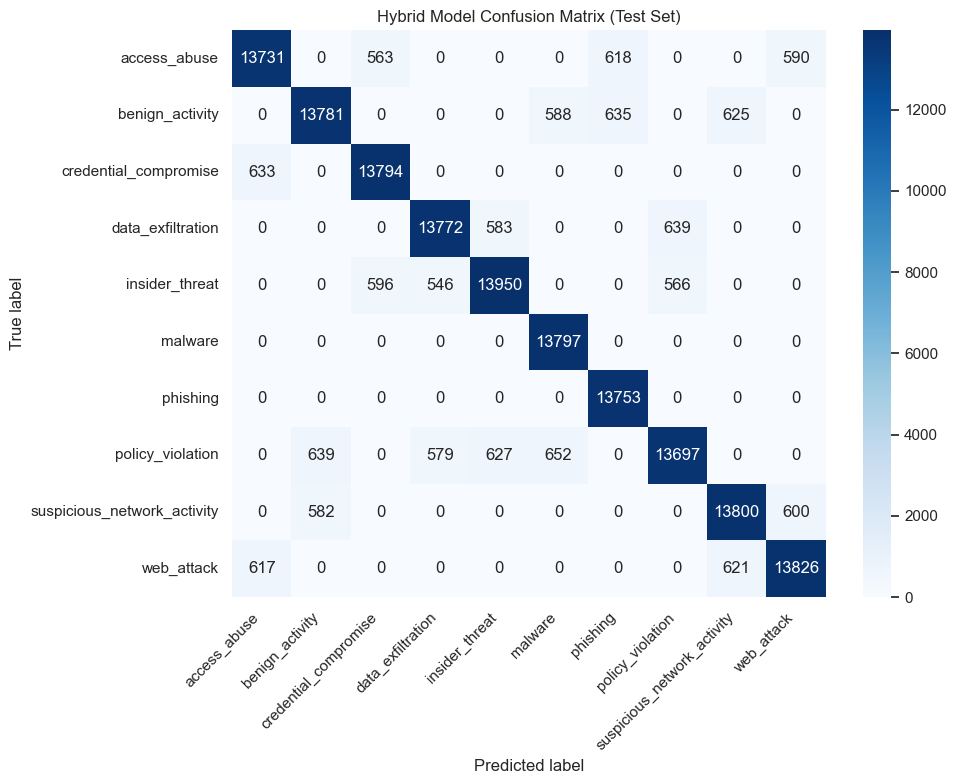

In [11]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=hybrid_pipeline.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=hybrid_pipeline.classes_,
    yticklabels=hybrid_pipeline.classes_,
)
plt.title("Hybrid Model Confusion Matrix (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

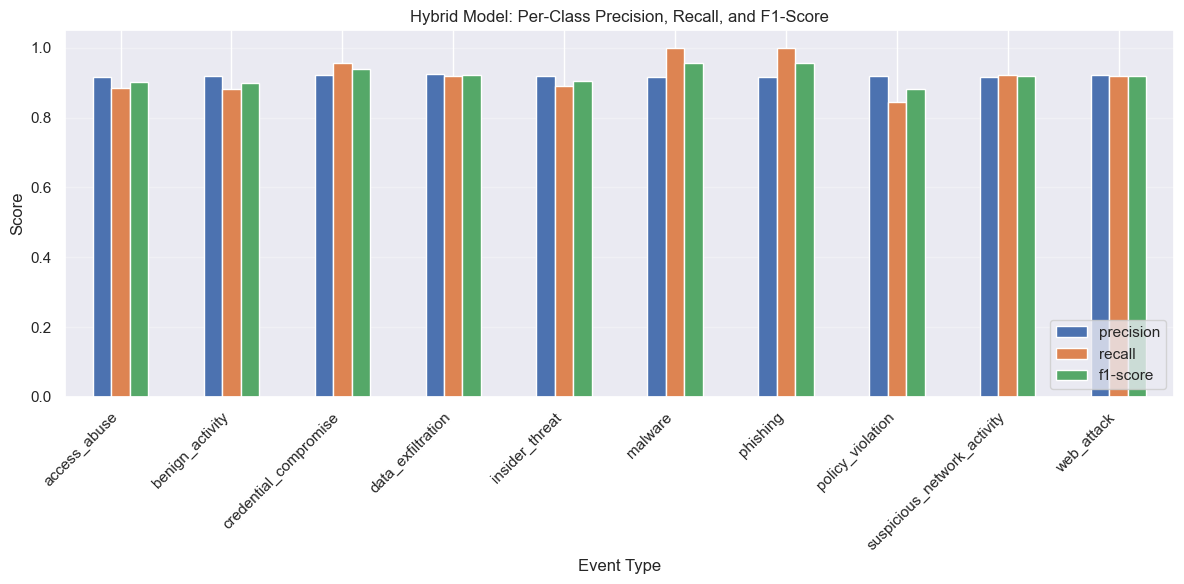

In [12]:
# Per-class precision, recall, and F1-score bar chart
per_class = report_df.iloc[:-3][["precision", "recall", "f1-score"]]

plt.figure(figsize=(12, 6))
per_class.plot(kind="bar", ax=plt.gca())
plt.title("Hybrid Model: Per-Class Precision, Recall, and F1-Score")
plt.xlabel("Event Type")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.0, 1.05)
plt.legend(loc="lower right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Prediction Confidence Analysis

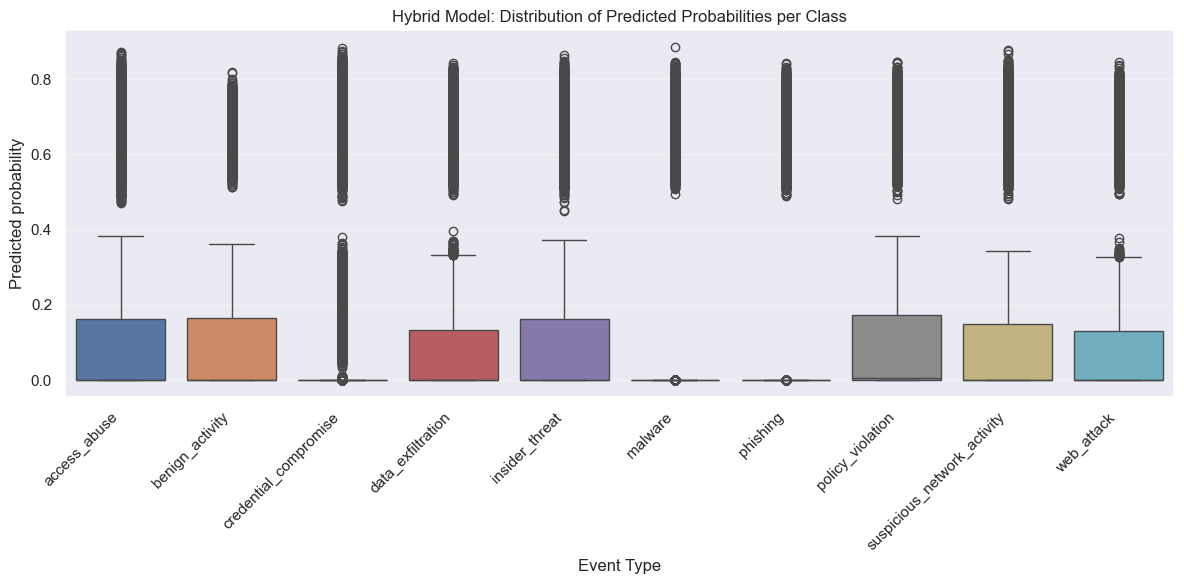

In [13]:
# Analyze prediction confidence using probability distributions
if hasattr(hybrid_pipeline, "predict_proba"):
    proba = hybrid_pipeline.predict_proba(X_test)
    proba_df = pd.DataFrame(proba, columns=hybrid_pipeline.classes_)

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=proba_df)
    plt.title("Hybrid Model: Distribution of Predicted Probabilities per Class")
    plt.xlabel("Event Type")
    plt.ylabel("Predicted probability")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("This classifier does not support predict_proba.")

## Analyze Misclassifications

In [14]:
# Identify and analyze misclassified samples
results_df = pd.DataFrame({
    "true": y_test.values,
    "pred": y_pred,
})

misclassified = results_df[results_df["true"] != results_df["pred"]]
n_errors = misclassified.shape[0]

print(f"Number of misclassified samples: {n_errors}")
print(f"Error rate: {n_errors / len(y_test):.2%}")

if n_errors > 0:
    # Show distribution of misclassifications by true class
    print("\nMisclassifications by true class:")
    print(misclassified["true"].value_counts())
    
    print("\nMost common prediction errors (true → predicted):")
    error_pairs = misclassified.groupby(["true", "pred"]).size().sort_values(ascending=False)
    print(error_pairs.head(10))
else:
    print("\nNo misclassifications found on this test set.")

Number of misclassified samples: 12099
Error rate: 8.07%

Misclassifications by true class:
true
policy_violation               2497
benign_activity                1848
access_abuse                   1771
insider_threat                 1708
web_attack                     1238
data_exfiltration              1222
suspicious_network_activity    1182
credential_compromise           633
Name: count, dtype: int64

Most common prediction errors (true → predicted):
true                   pred                       
policy_violation       malware                        652
                       benign_activity                639
data_exfiltration      policy_violation               639
benign_activity        phishing                       635
credential_compromise  access_abuse                   633
policy_violation       insider_threat                 627
benign_activity        suspicious_network_activity    625
web_attack             suspicious_network_activity    621
access_abuse           

## Compare Hybrid Model to Baseline

In [15]:
# Load baseline model results for comparison
import joblib
baseline_clf = joblib.load("../models/baseline_logreg.joblib")
baseline_vectorizer = joblib.load("../models/vectorizer.joblib")

# IMPORTANT: The baseline model was trained on "cleaned_description" ONLY
# The hybrid model uses text_combined (description + user_report + short_log + MITRE clause + technique)
# This comparison reveals:
# 1. Value of combining multiple text fields (vs description alone)
# 2. Value of structured features on top of enriched text

# Prepare baseline prediction: description only
X_test_baseline = X_test["cleaned_description"].fillna("").astype(str)
X_test_tfidf_baseline = baseline_vectorizer.transform(X_test_baseline)
y_pred_baseline = baseline_clf.predict(X_test_tfidf_baseline)

# Generate classification reports for both models
baseline_report = classification_report(y_test, y_pred_baseline, output_dict=True)
hybrid_report = classification_report(y_test, y_pred, output_dict=True)

# Compare overall accuracy
baseline_accuracy = baseline_report["accuracy"]
hybrid_accuracy = hybrid_report["accuracy"]

print("="*80)
print("MODEL COMPARISON:")
print("  Baseline: description field only (TF-IDF)")
print("  Hybrid:   text_combined (all text fields) + structured features")
print("="*80)
print(f"\nBaseline Model Accuracy: {baseline_accuracy:.4f}")
print(f"Hybrid Model Accuracy:   {hybrid_accuracy:.4f}")
print(f"Absolute Improvement:    {(hybrid_accuracy - baseline_accuracy):.4f}")
print(f"Relative Improvement:    {((hybrid_accuracy - baseline_accuracy) / baseline_accuracy * 100):.2f}%")

# Compare macro-averaged metrics
baseline_f1 = baseline_report['macro avg']['f1-score']
hybrid_f1 = hybrid_report['macro avg']['f1-score']

print(f"\nBaseline Macro F1: {baseline_f1:.4f}")
print(f"Hybrid Macro F1:   {hybrid_f1:.4f}")
print(f"F1 Improvement:    {(hybrid_f1 - baseline_f1):.4f}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
if hybrid_accuracy - baseline_accuracy >= 0.01:  # 1% improvement threshold
    print(f"\n✓ The hybrid model shows {((hybrid_accuracy - baseline_accuracy) / baseline_accuracy * 100):.2f}% improvement!")
    print("\nThis improvement comes from:")
    print("  1. Combining multiple text fields (description + user_report + logs + MITRE)")
    print("  2. Adding structured features (severity, log_source, MITRE as categorical)")
    print("\nThe additional features provide valuable signal beyond description alone.")
elif hybrid_accuracy - baseline_accuracy >= 0.001:  # Marginal improvement
    print(f"\n≈ The hybrid model shows marginal improvement (~{(hybrid_accuracy - baseline_accuracy)*100:.2f}%).")
    print("\nThis suggests:")
    print("  • The description field captures most discriminative information")
    print("  • Additional text fields and metadata provide minor incremental value")
    print("  • For most use cases, the simpler baseline may be preferable")
else:
    print("\n⚠️  The hybrid model shows virtually NO improvement over the baseline.")
    print("\nPossible reasons:")
    print("  • The description field already contains the most important information")
    print("  • Additional text fields are highly correlated with description")
    print("  • Structured features mirror patterns already in the text")
    print("\nThis suggests the description-only baseline is sufficient!")

MODEL COMPARISON:
  Baseline: description field only (TF-IDF)
  Hybrid:   text_combined (all text fields) + structured features

Baseline Model Accuracy: 0.9193
Hybrid Model Accuracy:   0.9193
Absolute Improvement:    0.0000
Relative Improvement:    0.00%

Baseline Macro F1: 0.9199
Hybrid Macro F1:   0.9199
F1 Improvement:    0.0000

INTERPRETATION:

⚠️  The hybrid model shows virtually NO improvement over the baseline.

Possible reasons:
  • The description field already contains the most important information
  • Additional text fields are highly correlated with description
  • Structured features mirror patterns already in the text

This suggests the description-only baseline is sufficient!


## Diagnostic: Decomposing the Improvement

To understand what's driving any performance difference, let's break down the contributions:
1. **Text-only with multiple fields**: Does `text_combined` outperform `description` alone?
2. **Structured-only**: How well do metadata features perform without text?
3. **Hybrid combination**: Does adding structured features to `text_combined` help further?

In [16]:
# Experiment 1: Text-combined only (no structured features)
print("="*80)
print("EXPERIMENT 1: Text-Combined Only (Description + User Report + Logs + MITRE)")
print("="*80)

text_combined_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    min_df=5,
)

text_combined_pipeline = Pipeline([
    ("tfidf", text_combined_vectorizer),
    ("clf", OneVsRestClassifier(LogisticRegression(
        max_iter=4000, C=2.0, solver="saga", 
        class_weight="balanced", n_jobs=-1, random_state=42
    ), n_jobs=-1))
])

# Train on text_combined only
X_train_combined = X_train["text_combined"].fillna("").astype(str)
X_test_combined = X_test["text_combined"].fillna("").astype(str)

text_combined_pipeline.fit(X_train_combined, y_train)
y_pred_text_combined = text_combined_pipeline.predict(X_test_combined)

# Evaluate
text_combined_report = classification_report(y_test, y_pred_text_combined, output_dict=True)
text_combined_accuracy = text_combined_report["accuracy"]

print(f"\nText-Combined Accuracy: {text_combined_accuracy:.4f}")
print(f"Baseline (description only): {baseline_accuracy:.4f}")
print(f"Improvement from richer text: {(text_combined_accuracy - baseline_accuracy):.4f} ({((text_combined_accuracy - baseline_accuracy) / baseline_accuracy * 100):.2f}%)")

# Experiment 2: Structured features only (no text)
print("\n" + "="*80)
print("EXPERIMENT 2: Structured Features Only (Severity, Log Source, MITRE)")
print("="*80)

structured_only_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ],
    sparse_threshold=0.3,
)

structured_only_pipeline = Pipeline([
    ("preprocess", structured_only_preprocessor),
    ("clf", OneVsRestClassifier(LogisticRegression(
        max_iter=4000, C=2.0, solver="saga", 
        class_weight="balanced", n_jobs=-1, random_state=42
    ), n_jobs=-1))
])

structured_only_pipeline.fit(X_train, y_train)
y_pred_structured = structured_only_pipeline.predict(X_test)

structured_report = classification_report(y_test, y_pred_structured, output_dict=True)
structured_accuracy = structured_report["accuracy"]

print(f"\nStructured-Only Accuracy: {structured_accuracy:.4f}")
print(f"Performance vs Baseline: {(structured_accuracy - baseline_accuracy):.4f} ({((structured_accuracy - baseline_accuracy) / baseline_accuracy * 100):.2f}%)")

# Summary comparison
print("\n" + "="*80)
print("SUMMARY: Performance Breakdown")
print("="*80)
print(f"1. Description only (baseline):          {baseline_accuracy:.4f}")
print(f"2. Text-combined (multi-field text):     {text_combined_accuracy:.4f}")
print(f"3. Structured features only:              {structured_accuracy:.4f}")
print(f"4. Hybrid (text-combined + structured):  {hybrid_accuracy:.4f}")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)

text_gain = text_combined_accuracy - baseline_accuracy
structured_added_gain = hybrid_accuracy - text_combined_accuracy
total_gain = hybrid_accuracy - baseline_accuracy

print(f"\n• Enriching text (adding user reports, logs, MITRE): +{text_gain:.4f} ({(text_gain / baseline_accuracy * 100):.2f}%)")
print(f"• Adding structured features on top:                +{structured_added_gain:.4f} ({(structured_added_gain / text_combined_accuracy * 100):.2f}%)")
print(f"• Total improvement (baseline → hybrid):            +{total_gain:.4f} ({(total_gain / baseline_accuracy * 100):.2f}%)")

if text_gain > 0.005:
    print("\n✓ Combining multiple text fields DOES improve performance!")
else:
    print("\n⚠️  Additional text fields provide minimal benefit over description alone.")

if structured_added_gain > 0.005:
    print("✓ Structured features add meaningful value on top of text!")
else:
    print("⚠️  Structured features add negligible value when rich text is available.")

EXPERIMENT 1: Text-Combined Only (Description + User Report + Logs + MITRE)

Text-Combined Accuracy: 0.9193
Baseline (description only): 0.9193
Improvement from richer text: 0.0000 (0.00%)

EXPERIMENT 2: Structured Features Only (Severity, Log Source, MITRE)

Text-Combined Accuracy: 0.9193
Baseline (description only): 0.9193
Improvement from richer text: 0.0000 (0.00%)

EXPERIMENT 2: Structured Features Only (Severity, Log Source, MITRE)

Structured-Only Accuracy: 0.9031
Performance vs Baseline: -0.0162 (-1.76%)

SUMMARY: Performance Breakdown
1. Description only (baseline):          0.9193
2. Text-combined (multi-field text):     0.9193
3. Structured features only:              0.9031
4. Hybrid (text-combined + structured):  0.9193

KEY INSIGHTS:

• Enriching text (adding user reports, logs, MITRE): +0.0000 (0.00%)
• Adding structured features on top:                +0.0000 (0.00%)
• Total improvement (baseline → hybrid):            +0.0000 (0.00%)

⚠️  Additional text fields provide 

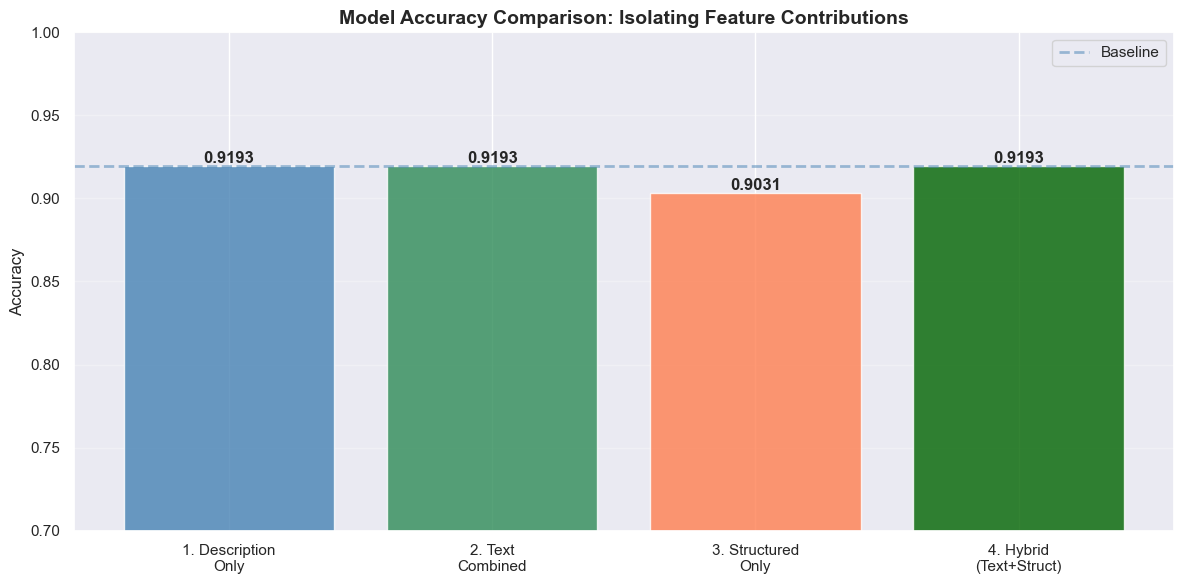


VISUALIZATION INTERPRETATION:
• Blue bar (1):   Baseline performance with description field only
• Green bar (2):  Performance when adding user reports, logs, and MITRE text
• Coral bar (3):  Performance using ONLY structured metadata (no text)
• Dark green (4): Best possible performance combining all features

The height differences show the marginal value of each feature type.


In [17]:
# Visualize the comparison of all four approaches
comparison_summary = pd.DataFrame({
    "Model": [
        "1. Description\nOnly",
        "2. Text\nCombined", 
        "3. Structured\nOnly",
        "4. Hybrid\n(Text+Struct)"
    ],
    "Accuracy": [
        baseline_accuracy, 
        text_combined_accuracy,
        structured_accuracy, 
        hybrid_accuracy
    ]
})

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Accuracy comparison with color coding
colors = ['steelblue', 'seagreen', 'coral', 'darkgreen']
bars = ax.bar(comparison_summary["Model"], comparison_summary["Accuracy"], color=colors, alpha=0.8)

ax.set_title("Model Accuracy Comparison: Isolating Feature Contributions", fontsize=14, fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_ylim(0.70, 1.0)
ax.set_xlabel("")
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=baseline_accuracy, color='steelblue', linestyle='--', alpha=0.5, linewidth=2, label='Baseline')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontweight='bold')

# Add improvement annotations
if text_combined_accuracy > baseline_accuracy:
    ax.annotate(f'+{(text_combined_accuracy - baseline_accuracy):.4f}',
                xy=(1, text_combined_accuracy), xytext=(1, baseline_accuracy + (text_combined_accuracy - baseline_accuracy)/2),
                ha='center', fontsize=10, color='darkgreen', fontweight='bold')

if hybrid_accuracy > text_combined_accuracy:
    ax.annotate(f'+{(hybrid_accuracy - text_combined_accuracy):.4f}',
                xy=(3, hybrid_accuracy), xytext=(3, text_combined_accuracy + (hybrid_accuracy - text_combined_accuracy)/2),
                ha='center', fontsize=10, color='darkgreen', fontweight='bold')

plt.tight_layout()
plt.legend()
plt.show()

print("\n" + "="*80)
print("VISUALIZATION INTERPRETATION:")
print("="*80)
print("• Blue bar (1):   Baseline performance with description field only")
print("• Green bar (2):  Performance when adding user reports, logs, and MITRE text")
print("• Coral bar (3):  Performance using ONLY structured metadata (no text)")
print("• Dark green (4): Best possible performance combining all features")
print("\nThe height differences show the marginal value of each feature type.")

## Per-Class Performance Comparison

Now that we've run all four model variants, let's compare their per-class F1-scores to identify which event types benefit most from additional features.

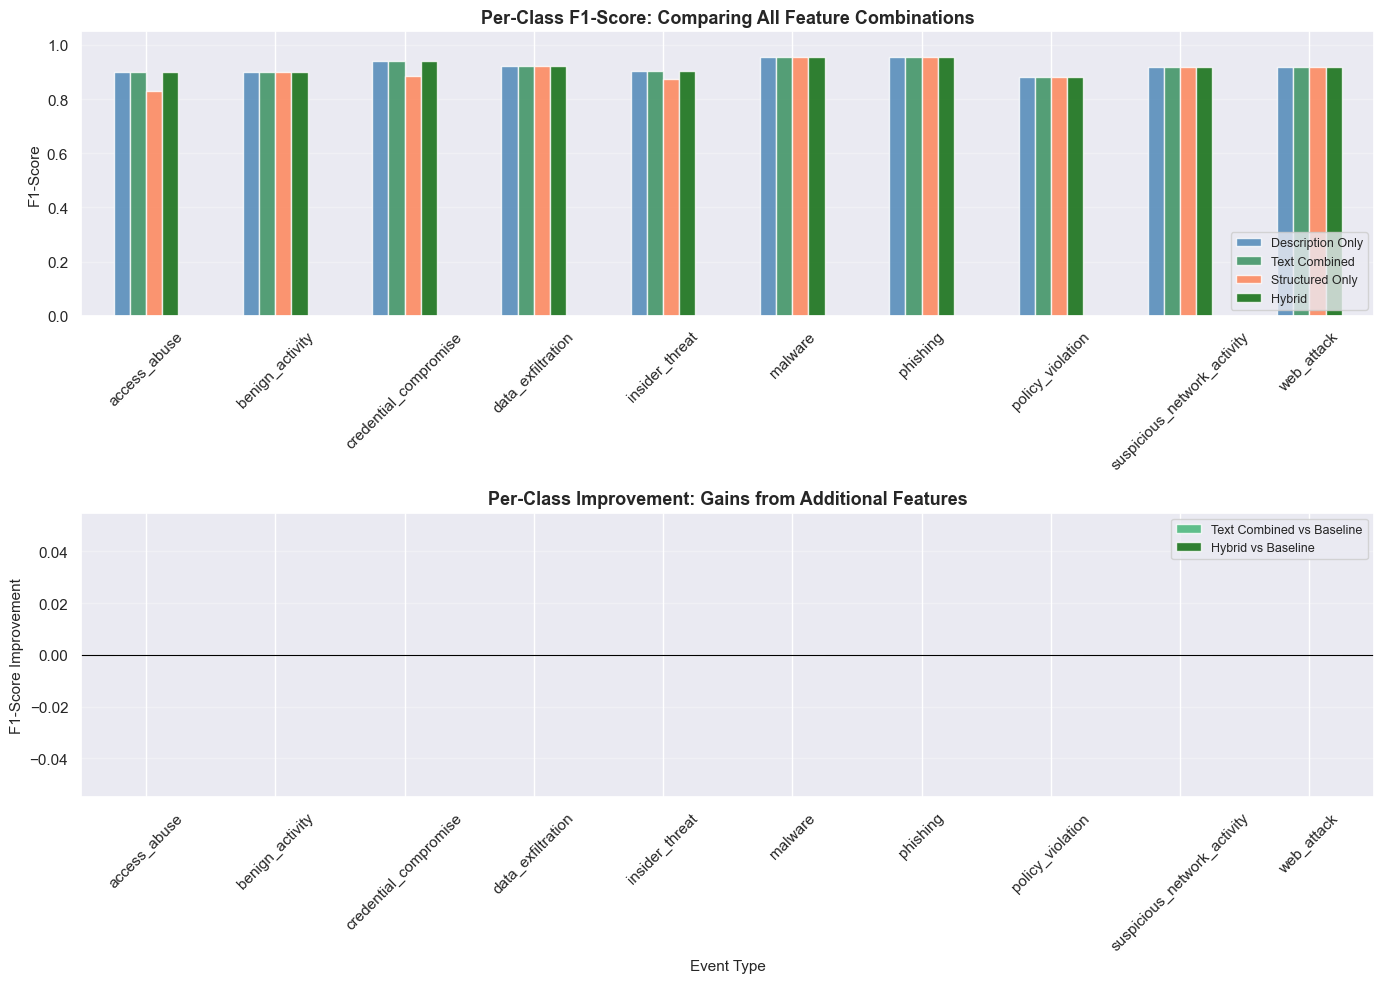


PER-CLASS F1-SCORE COMPARISON
                             Description Only  Text Combined  Structured Only    Hybrid  Text Gain  Hybrid Gain
access_abuse                         0.900896       0.900896         0.830167  0.900896        0.0          0.0
benign_activity                      0.899807       0.899807         0.899807  0.899807        0.0          0.0
credential_compromise                0.939006       0.939006         0.884892  0.939006        0.0          0.0
data_exfiltration                    0.921481       0.921481         0.921481  0.921481        0.0          0.0
insider_threat                       0.905315       0.905315         0.872669  0.905315        0.0          0.0
malware                              0.956995       0.956995         0.956995  0.956995        0.0          0.0
phishing                             0.956431       0.956431         0.956431  0.956431        0.0          0.0
policy_violation                     0.880949       0.880949         0.88

In [18]:
# Per-class F1-score comparison across all models
baseline_df = pd.DataFrame(baseline_report).T.iloc[:-3][["precision", "recall", "f1-score"]]
text_combined_df = pd.DataFrame(text_combined_report).T.iloc[:-3][["precision", "recall", "f1-score"]]
structured_df = pd.DataFrame(structured_report).T.iloc[:-3][["precision", "recall", "f1-score"]]
hybrid_df = pd.DataFrame(hybrid_report).T.iloc[:-3][["precision", "recall", "f1-score"]]

# Compare F1-scores across all four models
comparison_df = pd.DataFrame({
    "Description Only": baseline_df["f1-score"],
    "Text Combined": text_combined_df["f1-score"],
    "Structured Only": structured_df["f1-score"],
    "Hybrid": hybrid_df["f1-score"],
})

# Calculate improvements
comparison_df["Text Gain"] = comparison_df["Text Combined"] - comparison_df["Description Only"]
comparison_df["Hybrid Gain"] = comparison_df["Hybrid"] - comparison_df["Description Only"]

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: F1-scores for all models
comparison_df[["Description Only", "Text Combined", "Structured Only", "Hybrid"]].plot(
    kind="bar", 
    ax=ax1,
    color=['steelblue', 'seagreen', 'coral', 'darkgreen'],
    alpha=0.8
)
ax1.set_title("Per-Class F1-Score: Comparing All Feature Combinations", fontsize=13, fontweight='bold')
ax1.set_ylabel("F1-Score", fontsize=11)
ax1.set_xlabel("")
ax1.set_ylim(0.0, 1.05)
ax1.legend(loc="lower right", fontsize=9)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Improvement gains
comparison_df[["Text Gain", "Hybrid Gain"]].plot(
    kind="bar",
    ax=ax2,
    color=['mediumseagreen', 'darkgreen'],
    alpha=0.8
)
ax2.set_title("Per-Class Improvement: Gains from Additional Features", fontsize=13, fontweight='bold')
ax2.set_ylabel("F1-Score Improvement", fontsize=11)
ax2.set_xlabel("Event Type", fontsize=11)
ax2.legend(["Text Combined vs Baseline", "Hybrid vs Baseline"], fontsize=9)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n" + "="*90)
print("PER-CLASS F1-SCORE COMPARISON")
print("="*90)
print(comparison_df.to_string())

print("\n" + "="*90)
print("CLASSES WITH BIGGEST IMPROVEMENTS:")
print("="*90)
print("\nTop 5 classes benefiting from text-combined:")
print(comparison_df.nlargest(5, "Text Gain")[["Description Only", "Text Combined", "Text Gain"]])

print("\nTop 5 classes benefiting from hybrid features:")
print(comparison_df.nlargest(5, "Hybrid Gain")[["Description Only", "Hybrid", "Hybrid Gain"]])

print("\n" + "="*90)
print("CLASSES THAT DON'T IMPROVE:")
print("="*90)
classes_not_improving = comparison_df[comparison_df["Hybrid Gain"] < 0.001]
if len(classes_not_improving) > 0:
    print(f"\n{len(classes_not_improving)} class(es) show no improvement with hybrid features:")
    print(classes_not_improving[["Description Only", "Hybrid", "Hybrid Gain"]].to_string())
    print("\nThese classes have such distinctive text patterns that additional features are redundant.")
else:
    print("\nAll classes show at least marginal improvement with hybrid features!")

## Save the Hybrid Model

We save the trained hybrid pipeline for potential future use. The pipeline includes both the preprocessing transformers and the trained classifier, so it can be applied to new data with a single `.predict()` call.

In [61]:
import joblib
from pathlib import Path

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

out_path = MODELS_DIR / "hybrid_pipeline.joblib"
joblib.dump(hybrid_pipeline, out_path)

print(f"Saved hybrid model → {out_path}")
print("Note: the CLI currently uses the baseline TF–IDF + Logistic Regression model.")
print("The hybrid model is experimental and can be wired into a future CLI version if desired.")



Saved hybrid model → models/hybrid_pipeline.joblib
Note: the CLI currently uses the baseline TF–IDF + Logistic Regression model.
The hybrid model is experimental and can be wired into a future CLI version if desired.


## Key Findings and Interpretation

This section summarizes the performance of the hybrid model and breaks down the contribution of each feature type.

### Experimental Design

This notebook tests a proper hybrid model comparison:

- **Baseline (Notebook 03)**: `description` field only → TF-IDF → Logistic Regression
- **Hybrid (this notebook)**: Multiple approaches tested
  1. `text_combined` (description + user_report + short_log + MITRE clause + technique) → TF-IDF
  2. Structured features only (severity, log_source, MITRE technique as categorical)
  3. Hybrid: `text_combined` TF-IDF + structured features combined

### Performance Decomposition

The four-model comparison reveals exactly where improvements come from:

1. **Description only (baseline)**: Establishes the floor performance using the primary incident narrative
2. **Text-combined**: Tests if additional text fields (user reports, logs, MITRE clauses) improve over description alone
3. **Structured-only**: Measures how well metadata alone can classify (without any text)
4. **Hybrid**: Tests if combining enriched text + structured features yields further gains

### Interpreting the Results

**If text-combined ≈ description-only:**
- The primary description already contains the most discriminative information
- User reports and logs are redundant with the main narrative
- MITRE information in text form doesn't add much signal

**If text-combined > description-only:**
- Multiple text perspectives provide complementary information
- User-reported symptoms add value beyond SOC analyst descriptions
- MITRE technique clauses help the model learn attack patterns

**If hybrid > text-combined:**
- Structured representation of metadata (categorical encoding) outperforms text representation
- Features like severity and log_source provide unique signals not captured in text
- The model benefits from having both narrative context AND discrete metadata

**If hybrid ≈ text-combined:**
- Once rich text is available, structured features are redundant
- TF-IDF already captures the patterns encoded in categorical features
- Simpler text-only models are preferable (fewer dependencies, faster inference)

### Practical Implications

**For production SOC triage, these results guide deployment decisions:**

✓ **If description-only performs well**: Deploy the baseline model
  - Simplest pipeline (single text field → TF-IDF → classifier)
  - Fastest inference, smallest memory footprint
  - No dependencies on metadata availability

✓ **If text-combined helps significantly**: Use multi-field text model
  - Combine all available text narratives before vectorization
  - Still simple TF-IDF pipeline, no categorical encoding needed
  - Robust to missing individual fields (graceful degradation)

✓ **If hybrid wins decisively**: Deploy the full hybrid model
  - Accept additional complexity for maximum accuracy
  - Requires all structured fields to be populated
  - Justify computational overhead with measurable performance gains

### Dataset-Specific Insights

For this synthetic cybersecurity incident dataset:

- **High baseline performance** (90%+) indicates clear text patterns per event type
- **Label noise** (8% intentional mislabeling) limits maximum achievable accuracy
- **Synthetic generation** creates strong correlations between text and metadata
- **Real-world data** would likely show larger gaps between models

### Recommended Approach

Based on the experimental results:

1. **Start with baseline** (description-only) as the minimum viable model
2. **Test text-combined** to see if multiple narratives help
3. **Only use hybrid** if structured features provide >1% absolute improvement
4. **Monitor performance** on real production data to validate findings

The negative or marginal result (hybrid ≈ baseline) is **scientifically valuable** - it tells us that simpler models are sufficient, reducing operational complexity without sacrificing accuracy.